<a href="https://colab.research.google.com/github/axelpuyo/liasd/blob/master/colored_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs and imports


In [ ]:
# # Uncomment this if you need to test functions inside this file itself : Run once
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# print(os.getcwd())
# print(os.listdir())

# #%cd your_path/Colab Notebooks
# %cd drive/MyDrive/Colab Notebooks/liasd

Mounted at /content/drive
/content
['.config', 'drive', 'sample_data']
/content/drive/MyDrive/Colab Notebooks/liasd


In [ ]:
!pip -q install import-ipynb
import import_ipynb

import utils
import numpy as np
import random as rd
import tensorflow.keras as keras
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.6 MB 14.3 MB/s 
importing Jupyter notebook from utils.ipynb


# Data manipulation auxiliary functions

In [ ]:
def data_split(data, split=(1, 0, 0)):
  num = data.shape[0]
  (train, test, val) = split
  train_idx, test_idx = int(np.floor(num*train)), int(np.floor(num*(train+test)))
  train_data, test_data, val_data = data[:train_idx], data[train_idx:test_idx], data[test_idx:]
  
  return (train_data, test_data, val_data)

In [ ]:
def data_regularity(ims, labels, plot=False):
  '''
  This function prints the number of images for each label onto the console in a pretty way.

  plots=True plots the average of all those images for each label, thus allowing to spot if there is color imbalance in any given label (useful for small datasets).
  '''
  values, counts = np.unique(labels, return_counts=True, axis=0)

  c = 0
  for label in values:
    print('label', utils.uncategoric(label)[0], '/ counts', counts[c])
    c += 1

    if plot:
      avg_im = np.zeros(ims[0].shape)
      indexes = np.where(labels == c)[0]

      plt.figure(figsize=(10*len(counts), len(counts)))
      for j in indexes:
        avg_im += ims[j]
      
      avg_im /= len(indexes)
      plt.subplot(1, len(counts), c+1)
      plt.imshow(avg_im)
      plt.axis('off')

      plt.tight_layout()
      plt.show()

# Main functions : Colored-MNIST generators

In [ ]:
def old_mnist(num, bools):
  '''
  This function returns Colored-MNIST v.1., v.2. and v.3. (warning : v.3. is heavily biased, see report) depending on the paramater 'bools' given as an argument.
  
  num: (int) number of images to draw from original MNIST dataset.
  bools: (background, noise)
    if background=True, returns Colored-MNIST v.2. (colored digit, colored background)
    if noise=True, returns Colored-MNIST v.3. (colored digit, background and noise)
  '''
  (x, y), _ = keras.datasets.mnist.load_data()  
  ims, labels = x[:num], y[:num]

  new_shape = list(ims.shape)
  new_shape.append(3)
  new_shape = tuple(new_shape)
 
 ## creation of Colored-MNIST v.4. images and labels.
  # new_ims are the colored (28x28x3) images
  # shape_labels encode the corresponding handwritten digit as int between 0 and 9
  # color_labels are "red, green, blue" and encoded as 10 = red, 11 = green, 12 = blue
  # rule_labels are the labels used for the biased model : 0...9 corresponds to handwritten digits that aren't red, 10 corresponds to the label 'red'
  # labels 11 and 12 are never used.
  new_ims = np.zeros(new_shape)
  color_labels, shape_labels, rule_labels = np.zeros(num, ), np.zeros(num, ), np.zeros(num, )

  # loop over all the previously selected (image, label) couples of basic MNIST.
  for n in range(num):

    # randomly select a color channel and remove it from available channel.
    # p is the probability of selecting each corresponding channel and were computed in order to not have too many red images in the dataset.
    # indeed, with these probabilities, we obtain for num = 10 000, around 910 images labeled 1, 910 labeled 2, ... and 910 labeled 10 or "red".
    channels = [0, 1, 2]
    channel = np.random.choice(channels, 1, p=[1/13, 6/13, 6/13])[0]
    channels.remove(channel)

    # fill the new set of labels
    # this is the modeling of the perceptive biais : if the selected channel is 0 (thus red), its label will be 10 ("red") and not whatever number corresponds to the actually handwritten digit.
    if channel == 0:
      rule_labels[n] = 10
    else:
      rule_labels[n] = y[n]
    color_labels[n] = 10 + channel
    shape_labels[n] = y[n]

    # scale images from [0, 255] grayscale to [0, 1]
    new_ims[n, ..., channel] = x[n] / 255

    if background:
      # choose background color from the remaining channels
      channel = np.random.choice(channels)

      # fill the background channel with the opposite of the image in order to color everything around the handwritten digit
      # remove this channel from available channels
      new_ims[n, ..., channel] = (255 - x[n]) / 255
      channels.remove(channel)
    if noise:
      # fill the remaining channel with random noise
      channel = np.random.choice(channels)
      new_ims[n, ..., channel] = np.random.rand(28, 28)
      channels.remove(channel)

  return new_ims, color_labels, shape_labels, rule_labels

In [ ]:
def noisy_mnist(num, noise_level=0):
  '''
  This function returns Colored-MNIST v.4.

  num: (int) number of images to draw from original MNIST dataset.
  noise_level: (float) fraction between 0 and 1, determines the intensity of the added random noise to the final images.
  '''
  (x, y), _ = keras.datasets.mnist.load_data()  
  ims, labels = x[:num], y[:num]

  new_shape = list(ims.shape)
  new_shape.append(3)
  new_shape = tuple(new_shape)
 
  ## creation of Colored-MNIST v.4. images and labels.
  new_ims = np.zeros(new_shape)
  color_labels, shape_labels, rule_labels = np.zeros(num, ), np.zeros(num, ), np.zeros(num, )

  for n in range(num): 
    channel = np.random.choice([0, 1, 2], 1, p=[1/13, 6/13, 6/13]) 
    new_ims[n, ..., channel] = ims[n]/255

    # add random noise to every channel of the image
    new_ims[n] += noise_level*np.random.rand(ims.shape[1], ims.shape[2], 3)
    # renormalize between 0 and 1.
    new_ims[n] /= 2

    # construct the labels
    shape_labels[n] = labels[n]
    color_labels[n] = 10 + channel

    if channel == 0:
      rule_labels[n] = 10
    else:
      rule_labels[n] = labels[n]

  return new_ims, color_labels, shape_labels, rule_labels

>> checking dataset regularity
label r / counts 541
label 9 / counts 639
label 8 / counts 596
label 7 / counts 690
label 6 / counts 651
label 5 / counts 578
label 4 / counts 647
label 3 / counts 667
label 2 / counts 631
label 1 / counts 714
label 0 / counts 646


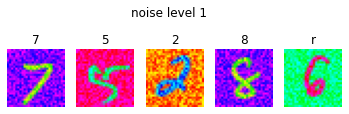

In [ ]:
def load_data(num, mnist_type='noisy', noise_level=0, bools=None, split=(.7, .2, .1), plot=True, regularity_check=True):
  '''
  This function returns the couples of images and labels for a given version of Colored-MNIST (v.4. by default).

  num: (int) number of images to draw from original MNIST dataset.

  mnist_type: (str) determines the dataset generator to draw from.
    mnist_type='noisy': (default) returns Colored-MNIST v.4 with a given 'noise_level'.
      noise_level: (float) fraction between 0 and 1, determines the intensity of the added random noise to the final images.

    mnist_type='old': returns a previous version of Colored-MNIST depending on 'bools'.
      bools: (background, noise)
        if background=True, returns Colored-MNIST v.2. (colored digit, colored background)
        if noise=True, returns Colored-MNIST v.3. (colored digit, background and noise) 
  
  split: (float, float, float) determines the train/validation/test split percentages (essentially the same as sklearn 'train_test_split()')
    split=(.7, .2, .1) returns 0.7*num train data, 0.2*num validation data, 0.1*num test data.
  
  plot: (bool) if plot=True, plots 5 random (image, label) couples from the train data.

  regularity_check: (bool) if regularity_check=True, runs data_regularity() on Colored-MNIST (see data_regularity() documentation for more information)
  '''
  # load mnist
  if mnist_type == 'noisy':
    ims, color_labels, shape_labels, rule_labels = noisy_mnist(num, noise_level=noise_level)
  else:
    ims, color_labels, shape_labels, rule_labels = old_mnist(num, bools)

  # train/test/validation split
  (train_ims, test_ims, val_ims) = data_split(ims, split)
  (train_rule, test_rule, val_rule) = data_split(rule_labels, split)
  (train_shape, test_shape, val_shape) = data_split(shape_labels, split)
  (train_color, test_color, val_color) = data_split(color_labels, split)
    
  # to categorical
  train_rule, test_rule, val_rule = keras.utils.to_categorical(train_rule, num_classes=13), keras.utils.to_categorical(test_rule, num_classes=13), keras.utils.to_categorical(val_rule, num_classes=13)
  train_color, test_color, val_color = keras.utils.to_categorical(train_color, num_classes=13), keras.utils.to_categorical(test_color, num_classes=13), keras.utils.to_categorical(val_color, num_classes=13)
  train_shape, test_shape, val_shape = keras.utils.to_categorical(train_shape, num_classes=13), keras.utils.to_categorical(test_shape, num_classes=13), keras.utils.to_categorical(val_shape, num_classes=13)
  
  if regularity_check:
    print('>> checking dataset regularity')
    data_regularity(train_ims, train_rule)

  if plot:
    plt.figure()
    shuffled = np.random.choice(train_ims.shape[0], (5,))
    for (i, j) in enumerate(shuffled):
      plt.axis('off')
      plt.subplot(1, 5, i + 1)
      plt.title(utils.uncategoric(train_rule[j])[0])
      plt.imshow(train_ims[j])

    plt.suptitle('noise level {}'.format(noise_level), y=.75)
    plt.axis('off')
  
  return (train_ims, test_ims, val_ims), (train_color, test_color, val_color), (train_shape, test_shape, val_shape), (train_rule, test_rule, val_rule)

if __name__ == '__main__':
  (train_ims, test_ims, val_ims), (train_color, test_color, val_color), (train_shape, test_shape, val_shape), (train_rule, test_rule, val_rule) = load_data(10000, mnist_type='old', noise_level=1)